# ECG analysis project
#### Author: Marian Petruk


### Import libraries, modules

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.signal import butter, sosfilt, sosfilt_zi, sosfiltfilt, lfilter, lfilter_zi, filtfilt, sosfreqz, resample


### Traverse data directory

In [26]:
import os
data_path = os.path.join("data", "Lviv-Biometric-Data-Set")
data_dirs = os.listdir(data_path)
data_dirs.remove('LICENSE')
data_dirs.remove("README.md")
print(len(data_dirs),"users = ", data_dirs)

USERID = 1
user_path = os.path.join(data_path, "user" + str(USERID))

user_ecg = os.listdir(user_path)
print("\nuser" + str(USERID), "has", len(user_ecg), "ecg samples =", user_ecg)

18 users =  ['user1', 'user10', 'user11', 'user12', 'user13', 'user14', 'user15', 'user16', 'user17', 'user18', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7', 'user8', 'user9']

user1 has 7 ecg samples = ['user1_02_26_16_42.npy', 'user1_02_29_18_37.npy', 'user1_02_29_18_38.npy', 'user1_03_09_18_16.npy', 'user1_03_10_11_14.npy', 'user1_03_10_15_09.npy', 'user1_03_10_15_10.npy']


### Load raw ECG signal

In [38]:
SAMPLEID = 0
data = np.load(os.path.join(user_path, user_ecg[SAMPLEID]))
print(type(data))
print(data)
print(data.shape)

<class 'numpy.ndarray'>
[6038. 6046. 6446. ... 7337. 7206. 6917.]
(3000,)


### Plot raw ecg sample

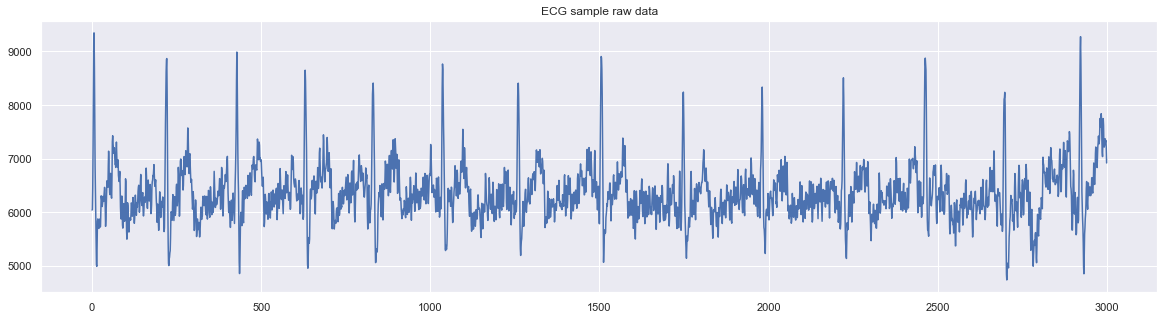

In [168]:
plt.figure(figsize=(20, 5))
plt.plot(data)
plt.title('ECG sample raw data')
plt.show()

### Filter the data from noice

#### **Butterworth Bandpass filter**

In [237]:
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data) # Filter data along one dimension using cascaded second-order sections. Using lfilter for each second-order section.
        return y

def butter_bandpass_filter_once(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    # Apply the filter to data. Use lfilter_zi to choose the initial condition of the filter.
    zi = sosfilt_zi(sos)
    z, _ = sosfilt(sos, data, zi=zi*data[0])
    return sos, z, zi

def butter_bandpass_filter_again(sos, z, zi):
    # Apply the filter again, to have a result filtered at an order the same as filtfilt.
    z2, _ = sosfilt(sos, z, zi=zi*z[0])
    return z2
    

def butter_bandpass_forward_backward_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfiltfilt(sos, data) # Apply a digital filter forward and backward to a signal.This function applies a linear digital filter twice, once forward and once backwards. The combined filter has zero phase and a filter order twice that of the original.
        return y

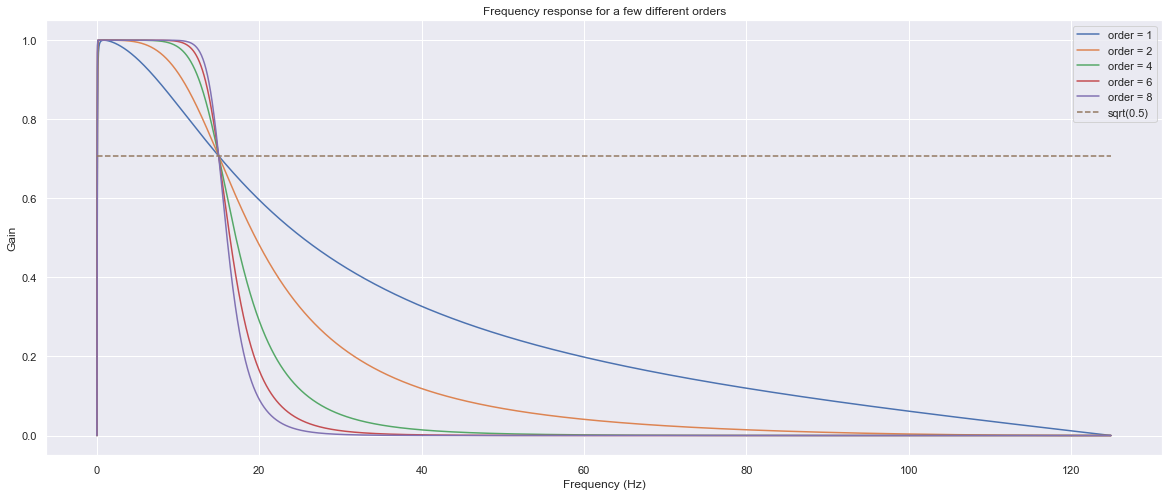

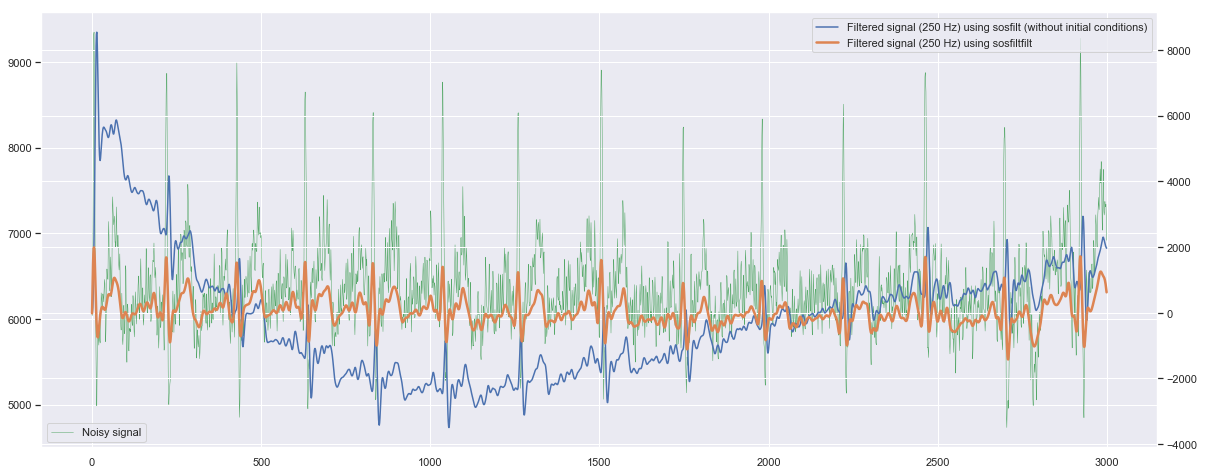

In [245]:
# Sample rate and desired cutoff frequencies (in Hz).
x = data
fs = 250
lowcut = 0.05
highcut = 15

# Plot the frequency response for a few different orders.
plt.figure(1, figsize=(20, 8))
plt.clf()
for order in [1, 2, 4, 6, 8]:
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = sosfreqz(sos, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency response for a few different orders')
plt.grid(True)
plt.legend(loc='best')

# Filter a noisy signal.

# T = 0.05
# nsamples = T * fs
# t = np.linspace(0, T, nsamples, endpoint=False)

plt.figure(2, figsize=(20, 8))
plt.clf()
plt.plot(x, 'g', linewidth=0.5, label='Noisy signal')
plt.legend(loc='lower left')
plt.twinx()
plt.plot(butter_bandpass_filter(x, lowcut, highcut, fs, order=4), label='Filtered signal (%g Hz) using sosfilt (without initial conditions)' % fs)
y = butter_bandpass_forward_backward_filter(x, lowcut, highcut, fs, order=4)
plt.plot(y, linewidth=2.5, label='Filtered signal (%g Hz) using sosfiltfilt' % fs)
plt.xlabel('time')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper right')

plt.show()

As we can see, it is better using `scipy.signal.sosfiltfilt` instead of `sosfilt` to apply the Butterworth filter. `sosfiltfilt` is the forward-backward filter. It applies the filter twice, once forward and once backward, resulting in zero phase delay.

#### Illustration of a phase delay/shift

Phase shift is any change that occurs in the phase of one quantity, or in the phase difference between two or more quantities. (c) Wikipedia 
<img width="300px" src="images/Phase_shift.png" alt="illustration of phase shift from wikipedia">

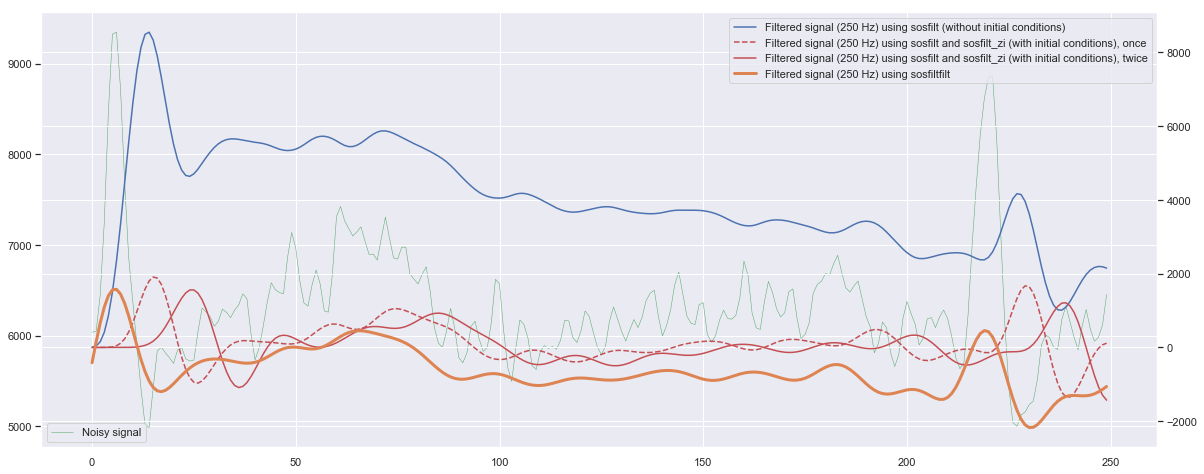

In [241]:
x = data[:fs]
plt.figure(figsize=(20,8))
plt.plot(x, 'g', linewidth=0.5, label='Noisy signal')
plt.legend(loc='lower left')
plt.twinx()
plt.plot(butter_bandpass_filter(x, lowcut, highcut, fs, order=4), label='Filtered signal (%g Hz) using sosfilt (without initial conditions)' % fs)
sos, z, zi = butter_bandpass_filter_once(x, lowcut, highcut, fs, order=5)
plt.plot(z, 'r--', label='Filtered signal (%g Hz) using sosfilt and sosfilt_zi (with initial conditions), once' % fs)
plt.plot(butter_bandpass_filter_again(sos, z, zi), 'r', label='Filtered signal (%g Hz) using sosfilt and sosfilt_zi (with initial conditions), twice' % fs)
plt.plot(butter_bandpass_forward_backward_filter(x, lowcut, highcut, fs, order=4), linewidth=3, label='Filtered signal (%g Hz) using sosfiltfilt' % fs)
plt.xlabel('time')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper right')

plt.show()

We can see phase delay on filtered singal using `sosfilt` without initial conditions and on both stages of `sosfilt` with initial conditions (`sosfilt_zi`). However, `sosfiltfilt` - a forward-backward digital filter has **zero phase delay/shift**.

## QRS

### Detect R-peaks

In [247]:
from ecg_detectors.ecgdetectors import MWA, panPeakDetect, searchBack

In [284]:
def pan_tompkins_detector(raw_ecg, squared, fs):
   
    N = int(0.12 * fs)
    mwa = MWA(squared, N)
#     mwa[:int(0.2 * fs)] = 0

    mwa_peaks = panPeakDetect(mwa, fs)

    r_peaks = searchBack(mwa_peaks, raw_ecg, N)

    return r_peaks

In [285]:
# Derivative - provides QRS slope information.
differentiated_ecg_measurements = np.ediff1d(y)

# Squaring - intensifies values received in derivative.
squared_ecg_measurements = differentiated_ecg_measurements ** 2

# Moving-window integration.
integration_window = 15 # Change proportionally when adjusting frequency (in samples)
integrated_ecg_measurements = np.convolve(squared_ecg_measurements, np.ones(integration_window))

# Fiducial mark - peak detection on integrated measurements.
# detected_peaks_indices = findpeaks(data=integrated_ecg_measurements,
# #                                                      limit=findpeaks_limit,
# #                                                      spacing=findpeaks_spacing)

# detected_peaks_values = integrated_ecg_measurements[detected_peaks_indices]

rpeaks = pan_tompkins_detector(data, squared_ecg_measurements, fs)
print(rpeaks)

[ 221  428  630  831 1036 1260 1505 1748 1981 2221 2463 2698 2922]


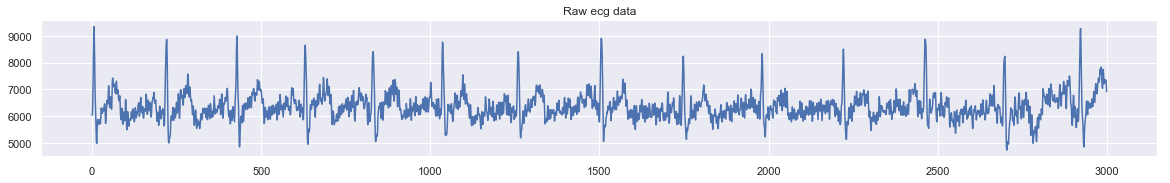

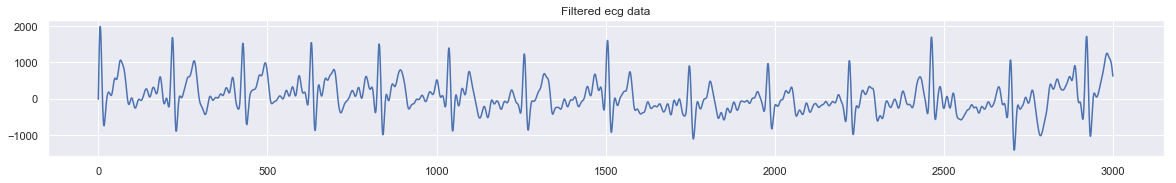

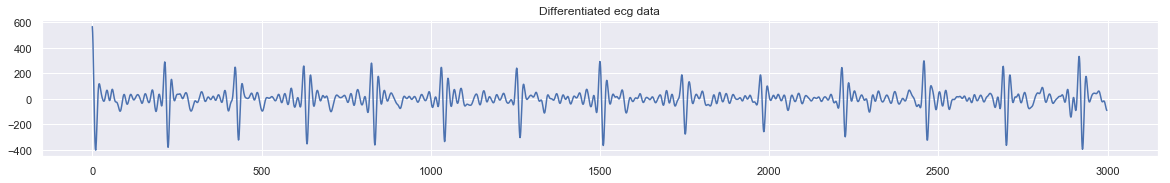

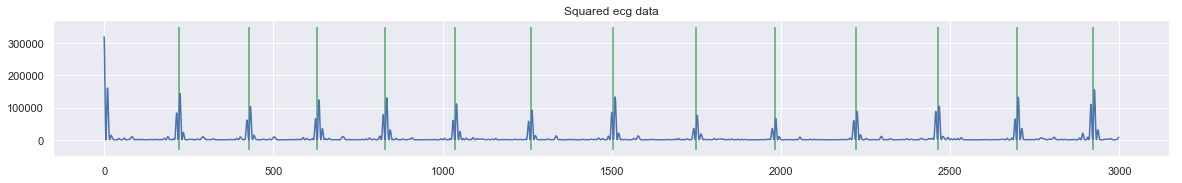

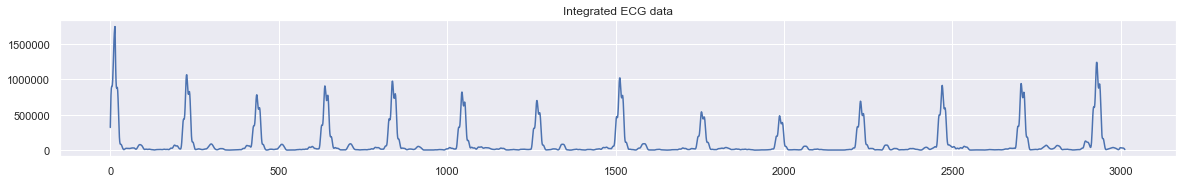

In [286]:
plt.figure(1, figsize=(20, 2.5))
plt.clf()
plt.plot(data)
plt.title('Raw ecg data')
plt.grid(True)

plt.figure(2, figsize=(20, 2.5))
plt.clf()
plt.plot(y)
plt.title('Filtered ecg data')
plt.grid(True)


plt.figure(3, figsize=(20, 2.5))
plt.clf()
plt.plot(differentiated_ecg_measurements)
plt.title('Differentiated ecg data')
plt.grid(True)


ymin = np.min(squared_ecg_measurements)
ymax = np.max(squared_ecg_measurements)
alpha = 0.1 * (ymax - ymin)
ymax += alpha
ymin -= alpha

plt.figure(4, figsize=(20, 2.5))
plt.clf()
plt.plot(squared_ecg_measurements)
plt.vlines(rpeaks, ymin, ymax,
               color='g',
               linewidth=1.5,
               label='R-peaks')
plt.title('Squared ecg data')
plt.grid(True)


plt.figure(5, figsize=(20, 2.5))
plt.clf()
plt.plot(integrated_ecg_measurements)
plt.title('Integrated ECG data')
plt.grid(True)

In [287]:
rr = []
i = 1
while i < len(rpeaks):
    rr.append(rpeaks[i] - rpeaks[i-1])
    i = i + 1
print(rr)

[207, 202, 201, 205, 224, 245, 243, 233, 240, 242, 235, 224]


In [292]:
# RMSSD: take the square root of the mean square of the differences
rmssd = np.sqrt(np.mean(np.square(np.diff(rr))))
print("RMSSD =", rmssd)

# Mean RR
mean_rr = np.mean(rr)
print("Mean RR =", mean_rr)

# SDNN
sdnn = np.std(rr)
print("SDNN =", sdnn)

# Mean HR
mean_hr = 60 * 1000/np.mean(rr)
print("Mean HR =", mean_hr)

# STD HR
# std_hr = np.std(hr)
#
# # Min HR
# min_hr = np.min(hr)
#
# # Max HR
# max_hr = np.max(hr)
#
# NNxx: sum absolute differences that are larger than 50ms
nnxx = np.sum(np.abs(np.diff(rr)) > 50)*1
print("NNxx =", nnxx)

# pNNx: fraction of nnxx of all rr-intervals
pnnx = 100 * nnxx / len(rr)
print("pNNx =", pnnx)


RMSSD = 10.317681205316699
Mean RR = 225.08333333333334
SDNN = 16.413705316662117
Mean HR = 266.5679378008145
NNxx = 0
pNNx = 0.0
